**Chapter 2 – End-to-end Machine Learning project**

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.*

*This notebook contains all the sample code and solutions to the exercices in chapter 2.*

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Get the data from the internet

Note:  There are problems running this now, because of a certificate authentication
issue.  Skip.

In [31]:
DATASETS_URL = "https://github.com/ageron/handson-ml/raw/master/datasets"

In [32]:
import os
import tarfile
from six.moves import urllib

HOUSING_PATH = "datasets/housing"
HOUSING_URL = DATASETS_URL + "/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.exists(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

IOError: [Errno socket error] [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:581)

## Loading the data once it's available locally

In [6]:
import pandas as pd
HOUSING_PATH = "datasets/housing"
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

## Eyeballing the data

Let's look at some statewide housing data for California.

Each row represents one district in California.
The districts range in size from 1 household to
over 6,000.  They vary in location, income level, and of course, median house value.

In [24]:
housing = load_housing_data()
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [19]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [20]:
print(housing.describe())

          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.00000

Try to explain the outliers in median housing age and median housing value. 

Saving figure attribute_histogram_plots


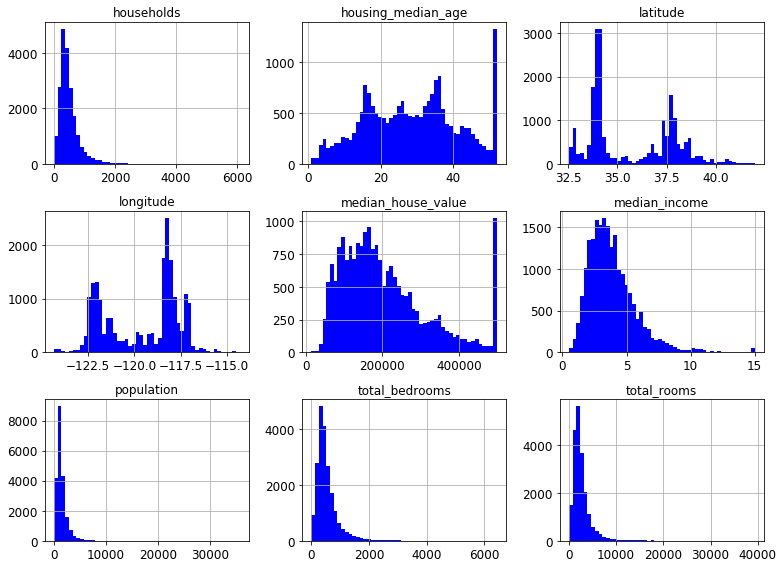

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(11,8))
save_fig("attribute_histogram_plots")
plt.show()

In [44]:
import numpy as np
import numpy.random as rnd
rnd.seed(42) # to make this notebook's output identical at every run

def split_train_test(data, test_ratio):
    shuffled_indices = rnd.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [23]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), len(test_set))

16512 4128


In [45]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [14]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
test_set.head()

index  longitude  latitude  housing_median_age  total_rooms  \
4       4    -122.25     37.85                52.0       1627.0   
5       5    -122.25     37.85                52.0        919.0   
11     11    -122.26     37.85                52.0       3503.0   
20     20    -122.27     37.85                40.0        751.0   
23     23    -122.27     37.84                52.0       1688.0   

    total_bedrooms  population  households  median_income  median_house_value  \
4            280.0       565.0       259.0         3.8462            342200.0   
5            213.0       413.0       193.0         4.0368            269700.0   
11           752.0      1504.0       734.0         3.2705            241800.0   
20           184.0       409.0       166.0         1.3578            147500.0   
23           337.0       853.0       325.0         2.1806             99700.0   

   ocean_proximity  
4         NEAR BAY  
5         NEAR BAY  
11        NEAR BAY  
20        NEAR BAY  
23        NEAR BAY

In [46]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
test_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
20046    -119.01     36.06                25.0       1505.0             NaN   
3024     -119.46     35.14                30.0       2943.0             NaN   
15663    -122.44     37.80                52.0       3830.0             NaN   
20484    -118.72     34.28                17.0       3051.0             NaN   
9814     -121.93     36.62                34.0       2351.0             NaN   

       population  households  median_income  median_house_value  \
20046      1392.0       359.0         1.6812             47700.0   
3024       1565.0       584.0         2.5313             45800.0   
15663      1310.0       963.0         3.4801            500001.0   
20484      1705.0       495.0         5.7376            218600.0   
9814       1063.0       428.0         3.7250            278000.0   

      ocean_proximity  income_cat  
20046          INLAND         2.0  
3024           INLAND         2.0  
15663        NEAR BAY         3.0  
20484       <1H OCEAN         4.0  
9814       NEAR OCEAN         3.0

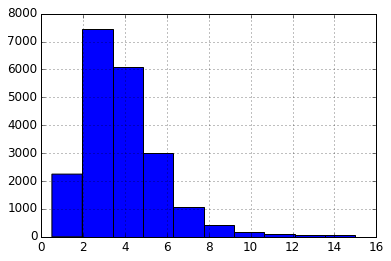

In [16]:
housing["median_income"].hist()

In [47]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

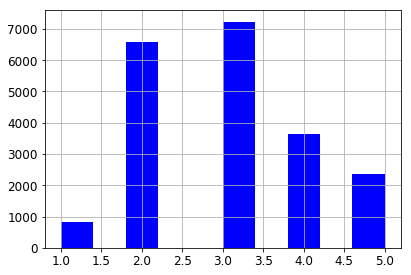

In [18]:
housing["income_cat"].hist()

Stratified sampling is a statistical sampling technique which attempts to guarantee
that a sample represents the true proportions of given attributes.  This is especially
useful when the sample size is small enough so that the chances of a non-representative
sample are fairly high.

Here's a toy example of how the data structures work.

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([0, 0, 1, 1])
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.5, random_state=0)
print(sss.get_n_splits(X, y))
print(sss)

3
StratifiedShuffleSplit(n_splits=3, random_state=0, test_size=0.5,
            train_size=None)


In [26]:
for train_index, test_index in sss.split(X, y):
      print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

TRAIN: [1 2] TEST: [3 0]
TRAIN: [0 2] TEST: [1 3]
TRAIN: [0 2] TEST: [3 1]


So we got three different splits; for each the proportion of 0 and 1's in `y`
reflects what it is in the data set as a whole (50/50).

Now let's try this on our data, but we'll just do one split, asking for the
proportions of the various income levels to be accurately preserved.

In [48]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [49]:
ss = split.split(housing, housing["income_cat"])

In [50]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [51]:
compare_props

Overall    Random  Stratified  Rand. %error  Strat. %error
1.0  0.039826  0.040213    0.039729      0.973236      -0.243309
2.0  0.318847  0.324370    0.318798      1.732260      -0.015195
3.0  0.350581  0.358527    0.350533      2.266446      -0.013820
4.0  0.176308  0.167393    0.176357     -5.056334       0.027480
5.0  0.114438  0.109496    0.114583     -4.318374       0.127011

Now that we've used the `income_cat` values to help us sample our data, let's drop
them, since they're clearly redundant.

In [52]:
for set in (strat_train_set, strat_test_set):
    set.drop("income_cat", axis=1, inplace=True)

# Discover and visualize the data to gain insights

In [22]:
housing = strat_train_set.copy()

Saving figure bad_visualization_plot


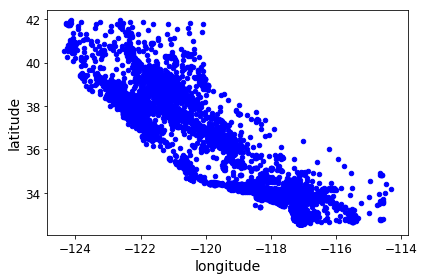

In [31]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


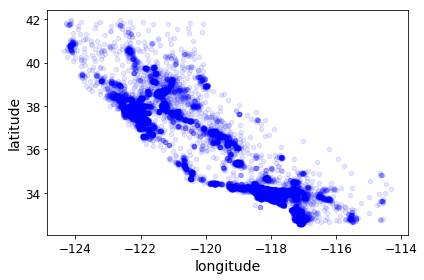

In [32]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

Saving figure housing_prices_scatterplot


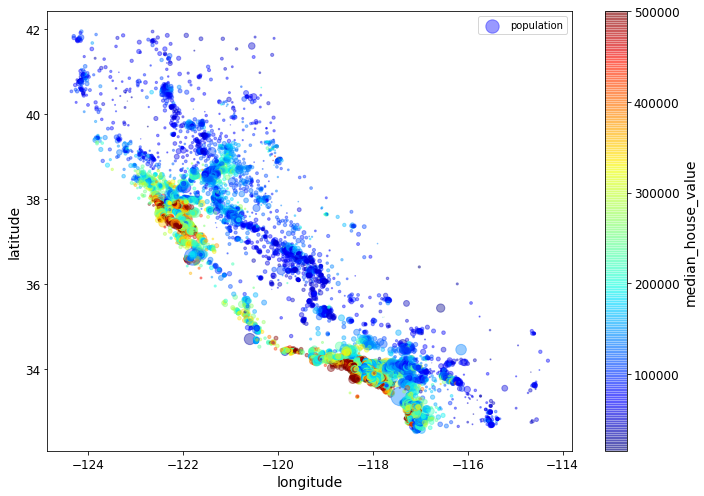

In [33]:
housing.plot(kind="scatter", x="longitude", y="latitude",
    s=housing['population']/100, label="population",
    c="median_house_value", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(10,7),
)
plt.legend()
save_fig("housing_prices_scatterplot")
plt.show()

Saving figure california_housing_prices_plot


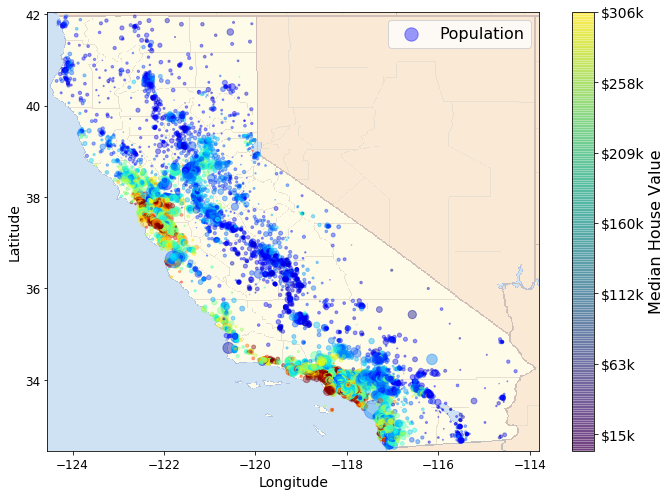

In [34]:
import matplotlib.image as mpimg
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/images/end_to_end_project/california.png')
# c is the attribute we'll map onto colors, s is the attribute we'll represent with circle size.
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

In [27]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Saving figure income_vs_house_value_scatterplot


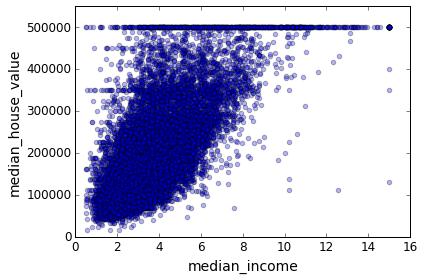

In [28]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.3)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")
plt.show()

Saving figure scatter_matrix_plot


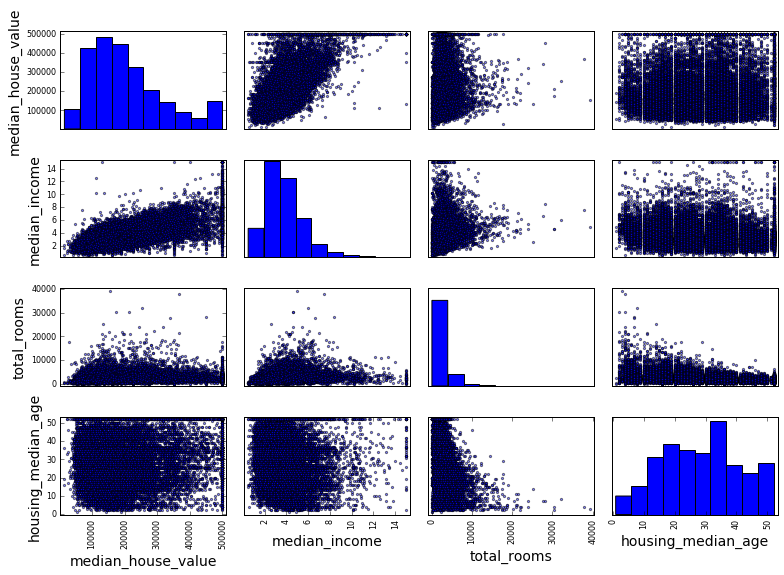

In [29]:
from pandas.tools.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(11, 8))
save_fig("scatter_matrix_plot")
plt.show()

In [30]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["population"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [31]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.199429
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

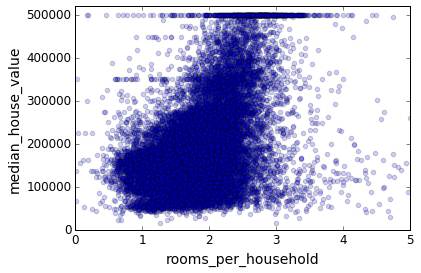

In [32]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

# Prepare the data for Machine Learning algorithms

In [33]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  16512.000000  16512.000000        16512.000000  16512.000000   
mean    -119.575834     35.639577           28.653101   2622.728319   
std        2.001860      2.138058           12.574726   2138.458419   
min     -124.350000     32.540000            1.000000      6.000000   
25%     -121.800000     33.940000           18.000000   1443.000000   
50%     -118.510000     34.260000           29.000000   2119.500000   
75%     -118.010000     37.720000           37.000000   3141.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    16354.000000  16512.000000  16512.000000   16512.000000   
mean       534.973890   1419.790819    497.060380       3.875589   
std        412.699041   1115.686241    375.720845       1.904950   
min          2.000000      3.000000      2.000000       0.499900   
25%        295.000000    784.000000    279.000000       2.566775   
50%        433.000000   1164.000000    408.000000       3.540900   
75%        644.000000   1719.250000    602.000000       4.744475   
max       6210.000000  35682.000000   5358.000000      15.000100   

       median_house_value  rooms_per_household  bedrooms_per_room  \
count        16512.000000         16512.000000       16354.000000   
mean        206990.920724             1.982840           0.212878   
std         115703.014830             1.214607           0.057379   
min          14999.000000             0.002547           0.100000   
25%         119800.000000             1.521534           0.175304   
50%         179500.000000             1.937963           0.203031   
75%         263900.000000             2.297169           0.239831   
max         500001.000000            55.222222           1.000000   

       population_per_household  
count              16512.000000  
mean                   3.096437  
std                   11.584826  
min                    0.692308  
25%                    2.431287  
50%                    2.817653  
75%                    3.281420  
max                 1243.333333

## Separating the dependent variable

The first step in preparing data for machine learning is to separate the values we want to predict from the values we want to learn how to predict with.  Our task will be to predict housing prices: 

In [53]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

Missing values are common in actual social statistics, because the techniques for collecting
data are often costly and failure prone.  Consider what collecting data by phone survey actually means.  The data we're discussing here are derived from census data, which, despite all the pains taken to guarantee its accuracy, often suffers from missing data points.

## Missing values

For example, the `total_bedrooms` attribute has many missing values. Here's an example.

In [56]:
housing.loc[290]

longitude              -122.16
latitude                 37.77
housing_median_age          47
total_rooms               1256
total_bedrooms             NaN
population                 570
households                 218
median_income            4.375
ocean_proximity       NEAR BAY
Name: 290, dtype: object

What is printed as `NaN` stands for "Not a Number".  This is an actual instance of the 
Python `float` type, but it behaves differently in calculations. Here it's just being
used to mean the data we want is unavailable.

We'll demonstrate
that by eliminating rows missing a `total_bedrooms` value.  First we make a copy of the data.

In [65]:
housing_copy = housing.copy()
housing_copy.loc[290]

longitude              -122.16
latitude                 37.77
housing_median_age          47
total_rooms               1256
total_bedrooms             NaN
population                 570
households                 218
median_income            4.375
ocean_proximity       NEAR BAY
Name: 290, dtype: object

Next we drop rows with missing values.

In [66]:
hc = housing_copy.dropna(subset=["total_bedrooms"])    # option 1
hc.loc[290]

KeyError: 'the label [290] is not in the [index]'

Having dropped all the rows missing a value for `total_bedrooms`, we take a look at the amount  of data we've lost:

In [67]:
print(len(housing),len(hc))
#set(housing.index.values) - set(hc.index.values)

16512 16354


That's not bad but it's still losing information. It could be that the districts we're
mssing data for are not randomly distributed.  For example, perhaps low income districts have more missing values. In that case, throwing away `Nan` rows for `total_bedrooms` will disproporationately affect the counts for **other attributes** in low income districts. 

An alternative strategy is to  eliminate the `total_bedrooms` column altogether.

In [30]:
housing_copy = housing.copy().iloc[21:24]
housing_copy.drop("total_bedrooms", axis=1)       # option 2

longitude  latitude  housing_median_age  total_rooms  population  \
21    -122.27     37.85                42.0       1639.0       929.0   
22    -122.27     37.84                52.0       2436.0      1015.0   
23    -122.27     37.84                52.0       1688.0       853.0   

    households  median_income  median_house_value ocean_proximity  
21       366.0         1.7135            159800.0        NEAR BAY  
22       478.0         1.7250            113900.0        NEAR BAY  
23       325.0         2.1806             99700.0        NEAR BAY

Still a third option with a significant advantages is to interpolate a reasonable
value for the missing values, say the median number of total bedrooms.  It might be better to scale this with total number of households, but let's keep it simple for now. 

In [38]:
housing_copy = housing.copy().iloc[21:24]
median = housing_copy["total_bedrooms"].median()
housing_copy["total_bedrooms"].fillna(median, inplace=True) # option 3
housing_copy

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
18086    -122.05     37.31                25.0       4111.0           538.0   
16718    -120.66     35.49                17.0       4422.0           945.0   
13600    -117.25     34.16                37.0       1709.0           278.0   

       population  households  median_income ocean_proximity  
18086      1585.0       568.0         9.2298       <1H OCEAN  
16718      2307.0       885.0         2.8285       <1H OCEAN  
13600       744.0       274.0         3.7188          INLAND

## Converting non numerical attributes

In [69]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median')
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.iloc[21:24]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
21    -122.05     37.31                25.0       4111.0           538.0   
22    -120.66     35.49                17.0       4422.0           945.0   
23    -117.25     34.16                37.0       1709.0           278.0   

    population  households  median_income  
21      1585.0       568.0         9.2298  
22      2307.0       885.0         2.8285  
23       744.0       274.0         3.7188

In [70]:
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [71]:
housing_num.median().values

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [72]:
imputer.strategy

u'median'

In [73]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   

       population  households  median_income ocean_proximity  
17606       710.0       339.0         2.7042       <1H OCEAN  
18632       306.0       113.0         6.4214       <1H OCEAN  
14650       936.0       462.0         2.8621      NEAR OCEAN  
3230       1460.0       353.0         1.8839          INLAND  
3555       4459.0      1463.0         3.0347       <1H OCEAN

In [74]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -121.89     37.29                38.0       1568.0           351.0   
1    -121.93     37.05                14.0        679.0           108.0   
2    -117.20     32.77                31.0       1952.0           471.0   
3    -119.61     36.31                25.0       1847.0           371.0   
4    -118.59     34.23                17.0       6592.0          1525.0   

   population  households  median_income  
0       710.0       339.0         2.7042  
1       306.0       113.0         6.4214  
2       936.0       462.0         2.8621  
3      1460.0       353.0         1.8839  
4      4459.0      1463.0         3.0347

## One hot encoding

In [75]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [76]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


The problem with this kind of encoding is that most machine learning algorithms
will assume that the numbers represent some kind of scale, and that therefore
being less than 1 hour from the ocean is "closer" to being inland than
it is to being near the ocean.   Although it's tempting to try to reorder the attributes so they represent "distance from water" but it's not clear this makes sense.  Is being on an island closer to or further from water than being near a bay?  An alternative is **one-hot encoding**.

In one-hot encoding we encode an attribute with 5 values as 5 different attributes,
each of which can take the value 0 or 1, and no two of which can be simultaneously 1.   Now the learning algorithm can treat each attribute a s a separate variable
without assuming any ordering among them.

In [77]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<type 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [78]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [48]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
encoder.fit_transform(housing_cat)

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

## Enhancing the data with computed values

In [49]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

housing_extra_attribs = pd.DataFrame(housing_extra_attribs, columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

longitude latitude housing_median_age total_rooms total_bedrooms population  \
0   -121.89    37.29                 38        1568            351        710   
1   -121.93    37.05                 14         679            108        306   
2    -117.2    32.77                 31        1952            471        936   
3   -119.61    36.31                 25        1847            371       1460   
4   -118.59    34.23                 17        6592           1525       4459   

  households median_income ocean_proximity rooms_per_household  \
0        339        2.7042       <1H OCEAN             4.62537   
1        113        6.4214       <1H OCEAN             6.00885   
2        462        2.8621      NEAR OCEAN             4.22511   
3        353        1.8839          INLAND             5.23229   
4       1463        3.0347       <1H OCEAN             4.50581   

  population_per_household  
0                   2.0944  
1                  2.70796  
2                  2.02597  
3                  4.13598  
4                  3.04785

## Scaling the data

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

num_pipeline.fit_transform(housing_num)

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

## Structuring pipelines

In [51]:
from sklearn.pipeline import FeatureUnion

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', LabelBinarizer()),
    ])

preparation_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])


In [52]:
housing_prepared = preparation_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [53]:
housing_prepared.shape

(16512, 16)

# Prepare the data for Machine Learning algorithms

Training a learner (we use **linear regression** here):

In [54]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Trying it out on some data.

In [55]:
# let's try the full pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = preparation_pipeline.transform(some_data)

print("Predictions:\t", lin_reg.predict(some_data_prepared))
print("Labels:\t\t", list(some_labels))

Predictions:	 [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


Evaluating the results.

In [56]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489219

An alternative evaluation.

In [57]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.895990018973

 Now  new learner, a decision tree regressor, trained, tested, and evaluated
 using root mean squrated error.

In [58]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Wow.

Well, wait a minute.  Didn't we just test on the training data? 

Yes, we did.  And that's exactly why we got a perfect score.  The decision
tree learner is a very powerful learner, and it will pretty much
always get a perfect score if you test on the training set.

In the next section, we try out **cross-validation**, which implements
the idea of separating training and test data, but also deals with
the problem that randomly splitting the data may generate overly
easy or overly hard test data.

We are also going to deal with another problem which we haven't talked about much because
we've steered clear of the particular properties of particular algorithms.
Machine learning algoithms generally present you with a number of decisions
you have to make **before** running the algorithm.  For example,
the random forest regressor introduced below uses a number
of learners simultaneously, each trained under slightly different
training circumstances, and to start with you have to decide
on the number of separate estimators that will be used.  Such
decisions, which must be made independently of training, are called
**hyper-parameters.**

# Fine-tune your model

## Cross validation

In [59]:
from sklearn.model_selection import cross_val_score

tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                              scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

In [60]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [ 69316.02634772  65498.84994772  71404.25935862  69098.46240168
  70580.30735263  75540.88413124  69717.93143674  70428.42648461
  75888.17618283  68976.12268448]
Mean: 70644.9446328
Standard deviation: 2938.93789263


In [61]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 66760.97371572  66962.61914244  70349.94853401  74757.02629506
  68031.13388938  71193.84183426  64968.13706527  68261.95557897
  71527.64217874  67665.10082067]
Mean: 69047.8379055
Standard deviation: 2735.51074287


In [62]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22252.738943108321

In [63]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 52869.23106834  49189.93801195  51726.73647871  54995.98190463
  50979.93079904  55978.43765914  52283.7609046   51001.92227546
  54447.35786983  53389.94422283]
Mean: 52686.3241195
Standard deviation: 1971.26547795


In [64]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69047.837905
std       2883.481504
min      64968.137065
25%      67138.239562
50%      68146.544734
75%      70982.868509
max      74757.026295
dtype: float64

In [65]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

## Grid Search: Fixing your hyper-parameters

In [66]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
    ]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'max_features': [2, 4, 6, 8], 'n_estimators': [3, 10, 30]}, {'bootstrap': [False], 'max_features': [2, 3, 4], 'n_estimators': [3, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [67]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [68]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [69]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64912.0351358 {'max_features': 2, 'n_estimators': 3}
55535.2786524 {'max_features': 2, 'n_estimators': 10}
52940.2696165 {'max_features': 2, 'n_estimators': 30}
60384.0908354 {'max_features': 4, 'n_estimators': 3}
52709.9199934 {'max_features': 4, 'n_estimators': 10}
50503.5985321 {'max_features': 4, 'n_estimators': 30}
59058.1153485 {'max_features': 6, 'n_estimators': 3}
52172.0292957 {'max_features': 6, 'n_estimators': 10}
49958.9555932 {'max_features': 6, 'n_estimators': 30}
59122.260006 {'max_features': 8, 'n_estimators': 3}
52441.5896087 {'max_features': 8, 'n_estimators': 10}
50041.4899416 {'max_features': 8, 'n_estimators': 30}
62371.1221202 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54572.2557534 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59634.0533132 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52456.0883904 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
58825.665239 {'bootstrap': False, 'max_features': 4, 'n_estimat

A very nice way of looking at the results of a grid search dictionary is to turn
it into a `pandas` data frame.


In [70]:
pd.DataFrame(grid_search.cv_results_)

mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0        0.055755         0.003181    -4.213572e+09     -1.122089e+09   
1        0.199918         0.008808    -3.084167e+09     -5.686194e+08   
2        0.557036         0.025331    -2.802672e+09     -4.390709e+08   
3        0.089936         0.003482    -3.646238e+09     -9.779480e+08   
4        0.338334         0.010385    -2.778336e+09     -5.111719e+08   
5        0.966047         0.022890    -2.550613e+09     -3.959620e+08   
6        0.139929         0.003044    -3.487861e+09     -9.302686e+08   
7        0.374688         0.007772    -2.721921e+09     -5.009736e+08   
8        1.116816         0.021737    -2.495897e+09     -3.848766e+08   
9        0.147904         0.002860    -3.495442e+09     -8.965714e+08   
10       0.488377         0.007839    -2.750120e+09     -5.032131e+08   
11       1.451734         0.021884    -2.504151e+09     -3.825022e+08   
12       0.081205         0.003204    -3.890157e+09      0.000000e+00   
13       0.254388         0.008918    -2.978131e+09      0.000000e+00   
14       0.104383         0.003176    -3.556220e+09      0.000000e+00   
15       0.358847         0.009087    -2.751641e+09      0.000000e+00   
16       0.162268         0.004215    -3.460459e+09      0.000000e+00   
17       0.541589         0.011160    -2.705352e+09      0.000000e+00   

   param_bootstrap param_max_features param_n_estimators  \
0              NaN                  2                  3   
1              NaN                  2                 10   
2              NaN                  2                 30   
3              NaN                  4                  3   
4              NaN                  4                 10   
5              NaN                  4                 30   
6              NaN                  6                  3   
7              NaN                  6                 10   
8              NaN                  6                 30   
9              NaN                  8                  3   
10             NaN                  8                 10   
11             NaN                  8                 30   
12           False                  2                  3   
13           False                  2                 10   
14           False                  3                  3   
15           False                  3                 10   
16           False                  4                  3   
17           False                  4                 10   

                                               params  rank_test_score  \
0              {'max_features': 2, 'n_estimators': 3}               18   
1             {'max_features': 2, 'n_estimators': 10}               11   
2             {'max_features': 2, 'n_estimators': 30}                9   
3              {'max_features': 4, 'n_estimators': 3}               16   
4             {'max_features': 4, 'n_estimators': 10}                8   
5             {'max_features': 4, 'n_estimators': 30}                3   
6              {'max_features': 6, 'n_estimators': 3}               13   
7             {'max_features': 6, 'n_estimators': 10}                5   
8             {'max_features': 6, 'n_estimators': 30}                1   
9              {'max_features': 8, 'n_estimators': 3}               14   
10            {'max_features': 8, 'n_estimators': 10}                6   
11            {'max_features': 8, 'n_estimators': 30}                2   
12  {'bootstrap': False, 'max_features': 2, 'n_est...               17   
13  {'bootstrap': False, 'max_features': 2, 'n_est...               10   
14  {'bootstrap': False, 'max_features': 3, 'n_est...               15   
15  {'bootstrap': False, 'max_features': 3, 'n_est...                7   
16  {'bootstrap': False, 'max_features': 4, 'n_est...               12   
17  {'bootstrap': False, 'max_features': 4, 'n_est...                4   

    split0_test_score       ...         split2_test_score  split2_tr

## Evaluating features

A model of the sort we've been looking at is a numerical method of 
combining feature values to reach a decision about some sort of problem.
Many learners provide easy ways to measure the importance
of particular features in reaching solutions, and that's sometimes
what we're most interested in.

Having done some systematic search for good learning parameters, let's
have a look at our features to see if our intuitions about which
ones would be most useful were correct.

There are some surprises.  Before looking at the results below, try to
predict them:

1.  Which is a better predictor of house price (in California), longitude
or latitude.
1.  Which is a better predictor of house price (in California), beinf
near the ocean or rooms per household?
1.  Which is a worse predictor, being on an island or housing age?

In [73]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  7.38167445e-02,   6.93425001e-02,   4.41741354e-02,
         1.80040251e-02,   1.65486595e-02,   1.80013616e-02,
         1.59794977e-02,   3.32716759e-01,   5.57319056e-02,
         1.05464076e-01,   8.70481930e-02,   9.90812199e-03,
         1.43083072e-01,   1.03976446e-04,   3.87833961e-03,
         6.19863203e-03])

In [74]:
extra_attribs = ["rooms_per_household", "population_per_household", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.33271675888101543, 'median_income'),
 (0.143083072155538, 'INLAND'),
 (0.10546407641519769, 'population_per_household'),
 (0.087048193008911728, 'bedrooms_per_room'),
 (0.073816744482605889, 'longitude'),
 (0.069342500136275007, 'latitude'),
 (0.055731905592885149, 'rooms_per_household'),
 (0.0441741353556422, 'housing_median_age'),
 (0.018004025077788675, 'total_rooms'),
 (0.018001361574586823, 'population'),
 (0.016548659526332148, 'total_bedrooms'),
 (0.015979497714769569, 'households'),
 (0.0099081219902823602, '<1H OCEAN'),
 (0.0061986320346514171, 'NEAR OCEAN'),
 (0.003878339607642522, 'NEAR BAY'),
 (0.00010397644587548846, 'ISLAND')]

# Extra material

## Randomized search CV

In [71]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor()
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error')
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd4fe486470>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd4fe486cc0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=0)

In [72]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

50239.6442738 {'max_features': 3, 'n_estimators': 121}
50307.8432326 {'max_features': 3, 'n_estimators': 187}
49185.0150532 {'max_features': 6, 'n_estimators': 88}
49133.3305418 {'max_features': 5, 'n_estimators': 137}
49021.6318804 {'max_features': 7, 'n_estimators': 197}
49636.8878839 {'max_features': 6, 'n_estimators': 39}
52273.457854 {'max_features': 2, 'n_estimators': 50}
54413.8506712 {'max_features': 1, 'n_estimators': 184}
51953.3364641 {'max_features': 2, 'n_estimators': 71}
49174.1414792 {'max_features': 6, 'n_estimators': 140}


In [75]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_transformed = preparation_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_transformed)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47728.481110152476

## Label Binarizer hack
`LabelBinarizer`'s `fit_transform()` method only accepts one parameter `y` (because it was meant for labels, not predictors), so it does not work in a pipeline where the final estimator is a supervised estimator because in this case its `fit()` method takes two parameters `X` and `y`.

This hack creates a supervision-friendly `LabelBinarizer`.

In [76]:
class SupervisionFriendlyLabelBinarizer(LabelBinarizer):
    def fit_transform(self, X, y=None):
        return super(SupervisionFriendlyLabelBinarizer, self).fit_transform(X)

# Replace the Labelbinarizer with a SupervisionFriendlyLabelBinarizer
cat_pipeline.steps[1] = ("label_binarizer", SupervisionFriendlyLabelBinarizer())

# Now you can create a full pipeline with a supervised predictor at the end.
full_pipeline = Pipeline([
        ("preparation", preparation_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline.fit(housing, housing_labels)
full_pipeline.predict(some_data)

array([ 210644.60459286,  317768.80697211,  210956.43331178,
         59218.98886849,  189747.55849879])

## Model persistence using joblib

In [77]:
from sklearn.externals import joblib

In [78]:
joblib.dump(final_model, "my_random_forest_regressor.pkl")

['my_random_forest_regressor.pkl']

In [79]:
final_model_loaded = joblib.load("my_random_forest_regressor.pkl")
final_model_loaded

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

## Example SciPy distributions for `RandomizedSearchCV`

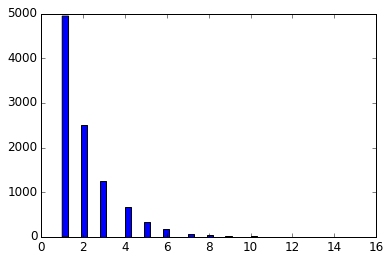

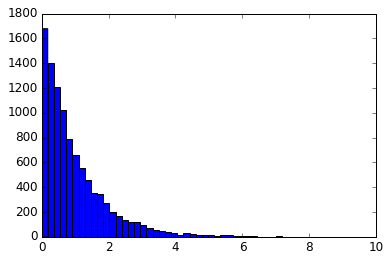

In [80]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000)
expon_distrib=expon(scale=1).rvs(10000)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

# Exercise solutions

**Coming soon**